# Community Analysis with Barley Dataset

This notebook demonstrates community ecology analysis using the barley dataset from vega-datasets.

We'll treat:
- **Sites**: Different locations
- **Species**: Barley varieties
- **Abundances**: Yield values
- **Environmental variables**: Year

In [1]:
# Import required libraries
import nuee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vega_datasets import data

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load and Prepare Data

In [2]:
# Load barley dataset
barley_df = data.barley()
print(f"Dataset shape: {barley_df.shape}")
print(f"\nDataset info:")
print(barley_df.info())
print(f"\nFirst few rows:")
barley_df.head(10)

Dataset shape: (120, 4)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   yield    120 non-null    float64
 1   variety  120 non-null    object 
 2   year     120 non-null    int64  
 3   site     120 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.9+ KB
None

First few rows:


,yield,variety,year,site
0,27.00000,Manchuria,1931,University Farm
1,48.86667,Manchuria,1931,Waseca
2,27.43334,Manchuria,1931,Morris
3,39.93333,Manchuria,1931,Crookston
4,32.96667,Manchuria,1931,Grand Rapids
5,28.96667,Manchuria,1931,Duluth
6,43.06666,Glabron,1931,University Farm
7,55.20000,Glabron,1931,Waseca
8,28.76667,Glabron,1931,Morris
9,38.13333,Glabron,1931,Crookston


In [3]:
# Reshape data: sites x species matrix
# Create a pivot table with sites as rows and varieties as columns
community_matrix = barley_df.pivot_table(
    index='site',
    columns='variety', 
    values='yield',
    aggfunc='mean'
).fillna(0)

print(f"Community matrix shape: {community_matrix.shape}")
print(f"\nSites: {list(community_matrix.index)}")
print(f"\nVarieties: {list(community_matrix.columns)}")
print(f"\nCommunity matrix:")
community_matrix

Community matrix shape: (6, 10)

Sites: ['Crookston', 'Duluth', 'Grand Rapids', 'Morris', 'University Farm', 'Waseca']

Varieties: ['Glabron', 'Manchuria', 'No. 457', 'No. 462', 'No. 475', 'Peatland', 'Svansota', 'Trebi', 'Velvet', 'Wisconsin No. 38']

Community matrix:


variety,Glabron,Manchuria,No. 457,No. 462,No. 475,Peatland,Svansota,Trebi,Velvet,Wisconsin No. 38
site,,,,,,,,,,
Crookston,32.150000,36.45000,40.000000,39.549995,38.116665,33.416665,30.550000,44.383330,36.699995,42.883335
Duluth,27.766670,25.76667,28.150000,25.300000,30.216665,31.683335,23.966665,32.266665,24.383335,30.466665
Grand Rapids,21.783330,27.55000,25.816670,22.416670,17.466665,30.733335,23.150000,25.200000,27.633330,27.566670
Morris,31.950000,30.90000,36.116670,38.683335,33.416665,36.533335,30.400000,45.200000,32.483330,38.316670
University Farm,39.933330,26.95000,34.850005,31.083335,27.333335,30.416670,31.283335,32.816665,33.350000,38.650000
Waseca,46.466665,41.16667,50.150000,55.233350,44.016670,42.299995,42.916665,56.533300,43.816665,58.483335


In [4]:
# Create environmental data (year effects by site)
env_data = barley_df.groupby('site').agg({
    'yield': ['mean', 'std'],
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
}).reset_index()
env_data.columns = ['site', 'mean_yield', 'std_yield', 'year']
env_data = env_data.set_index('site')
print("Environmental data:")
env_data

Environmental data:


,mean_yield,std_yield,year
site,,,
Crookston,37.419998,8.089373,1931
Duluth,27.996667,4.037034,1931
Grand Rapids,24.931667,6.598109,1931
Morris,35.400000,8.186352,1931
University Farm,32.666668,6.159344,1931
Waseca,48.108332,9.464096,1931


## Diversity Analysis

Calculate diversity indices for each site.

In [5]:
# Calculate diversity indices
shannon_div = nuee.shannon(community_matrix)
simpson_div = nuee.simpson(community_matrix)
richness = nuee.specnumber(community_matrix)
evenness_div = nuee.evenness(community_matrix)

# Create diversity summary
diversity_summary = pd.DataFrame({
    'Shannon': shannon_div.values,
    'Simpson': simpson_div.values,
    'Richness': richness.values,
    'Evenness': evenness_div.values
}, index=community_matrix.index)

print("Diversity indices by site:")
diversity_summary

Diversity indices by site:


,Shannon,Simpson,Richness,Evenness
site,,,,
Crookston,2.296039,0.101303,10,0.997157
Duluth,2.297190,0.101078,10,0.997657
Grand Rapids,2.291724,0.102103,10,0.995283
Morris,2.295353,0.101490,10,0.996859
University Farm,2.294957,0.101541,10,0.996687
Waseca,2.294524,0.101643,10,0.996499


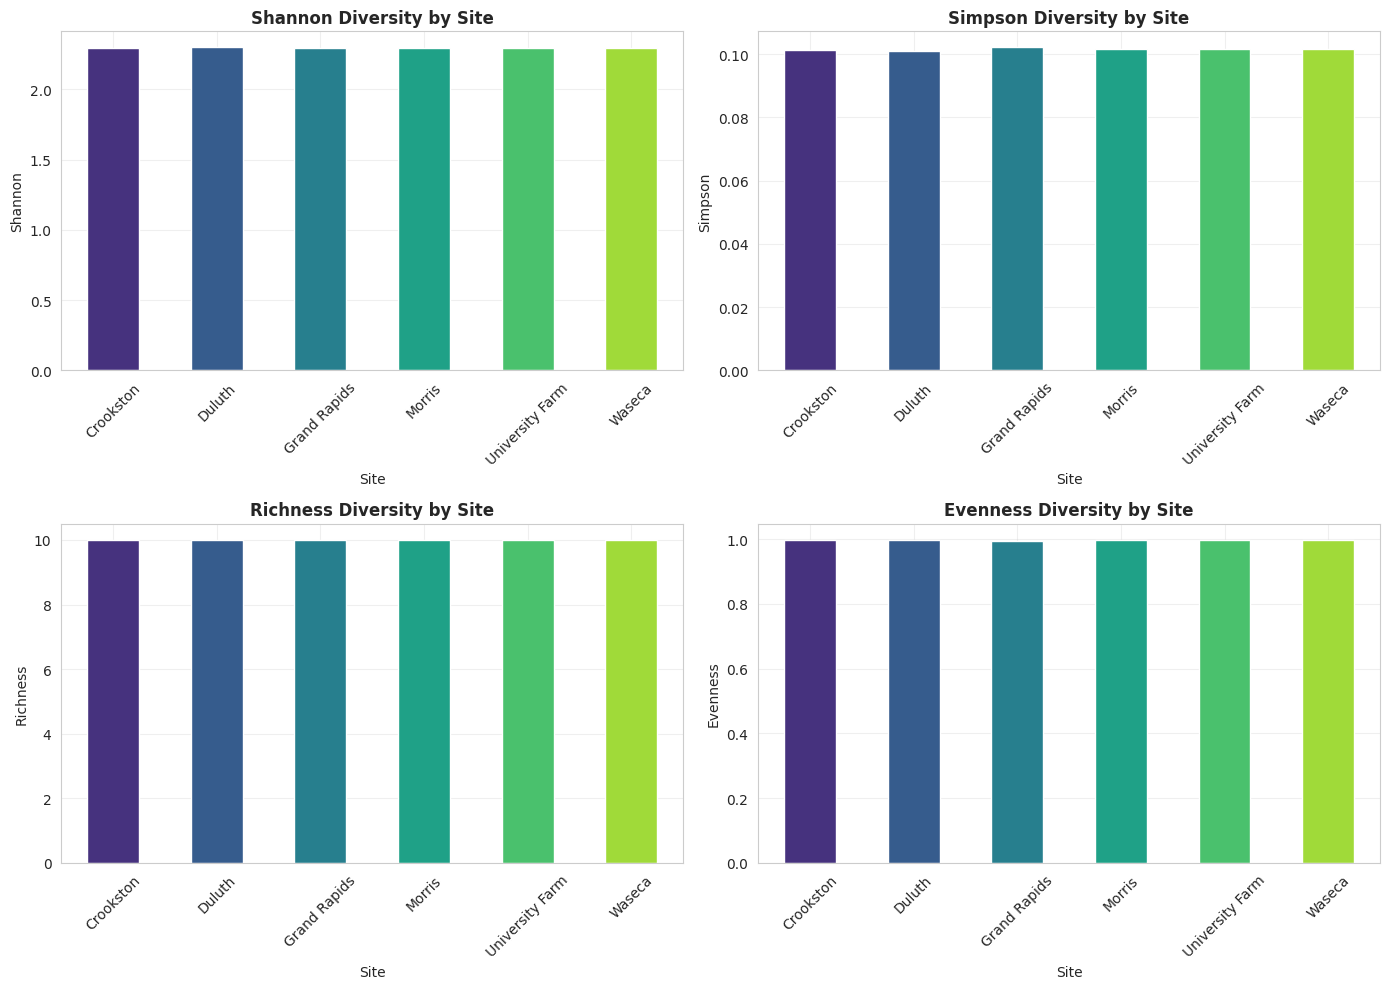

In [6]:
# Visualize diversity patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

metrics = ['Shannon', 'Simpson', 'Richness', 'Evenness']
colors = sns.color_palette('viridis', n_colors=len(diversity_summary))

for idx, metric in enumerate(metrics):
    diversity_summary[metric].plot(kind='bar', ax=axes[idx], color=colors)
    axes[idx].set_title(f'{metric} Diversity by Site', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Site')
    axes[idx].set_ylabel(metric)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Ordination Analysis

### NMDS (Non-metric Multidimensional Scaling)

In [7]:
# Perform NMDS ordination
nmds_result = nuee.metaMDS(community_matrix, k=2, distance='bray', trymax=50, trace=True)
print(f"\nNMDS Stress: {nmds_result.stress:.4f}")
print(f"Converged: {nmds_result.converged}")

Applying square root transformation
NMDS stress: 0.0560
NMDS converged

NMDS Stress: 0.0560
Converged: True


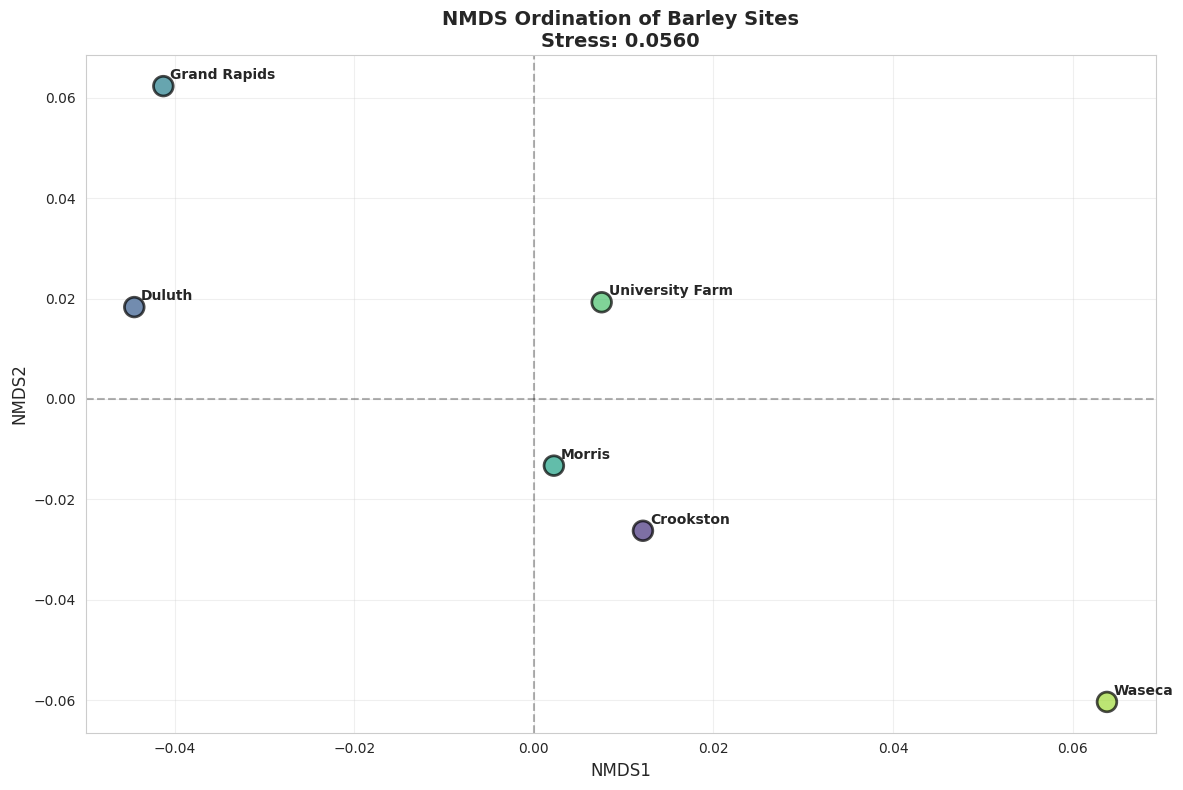

In [8]:
# Extract NMDS scores
nmds_scores = pd.DataFrame(
    nmds_result.points,
    columns=['NMDS1', 'NMDS2'],
    index=community_matrix.index
)

# Plot NMDS ordination
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(nmds_scores['NMDS1'], nmds_scores['NMDS2'], 
           s=200, alpha=0.7, c=colors, edgecolors='black', linewidth=2)

# Add site labels
for idx, site in enumerate(nmds_scores.index):
    ax.annotate(site, 
                (nmds_scores['NMDS1'].iloc[idx], nmds_scores['NMDS2'].iloc[idx]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold')

ax.set_xlabel('NMDS1', fontsize=12)
ax.set_ylabel('NMDS2', fontsize=12)
ax.set_title(f'NMDS Ordination of Barley Sites\nStress: {nmds_result.stress:.4f}',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### PCA with Biplot

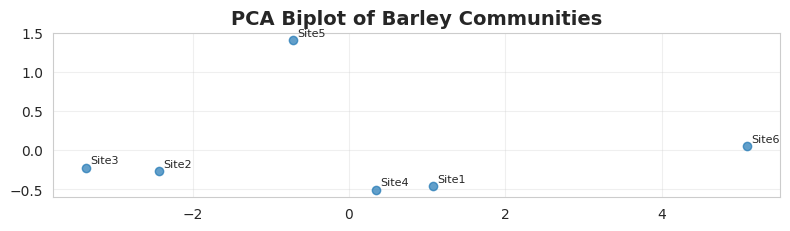

In [9]:
# Perform PCA
pca_result = nuee.pca(community_matrix)

# Create biplot
fig = nuee.biplot(pca_result)
plt.title('PCA Biplot of Barley Communities', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Dissimilarity Analysis

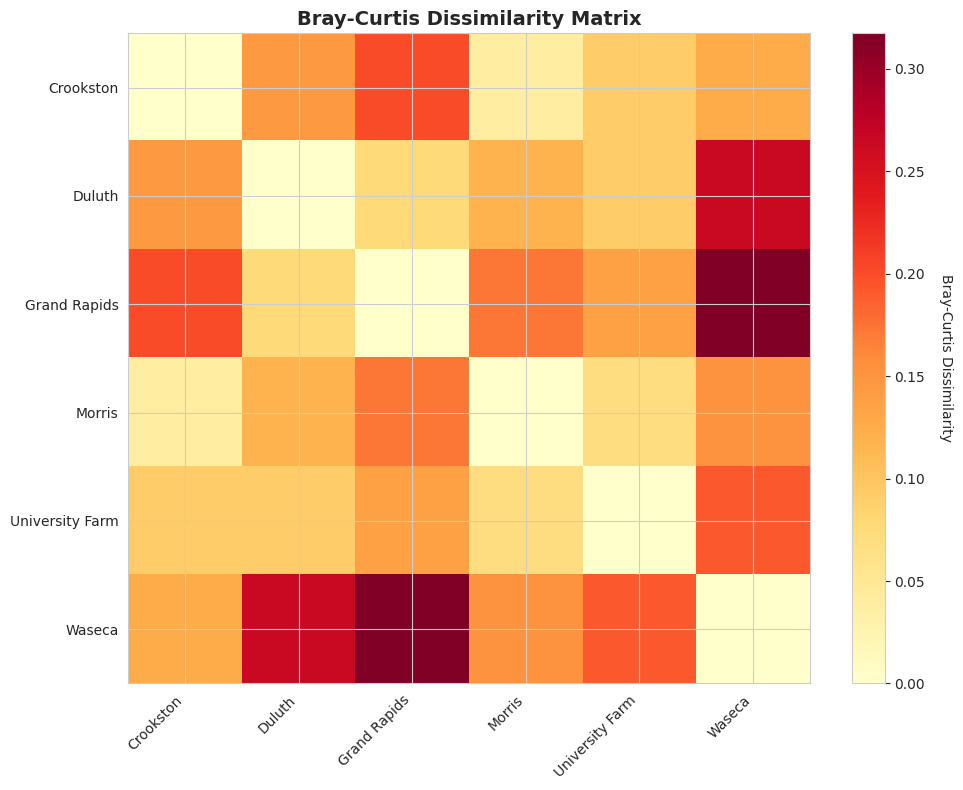

In [10]:
# Calculate Bray-Curtis dissimilarity
dist_matrix = nuee.vegdist(community_matrix, method='bray')

# Visualize dissimilarity matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(dist_matrix, cmap='YlOrRd', aspect='auto')

# Set ticks and labels
ax.set_xticks(np.arange(len(community_matrix.index)))
ax.set_yticks(np.arange(len(community_matrix.index)))
ax.set_xticklabels(community_matrix.index, rotation=45, ha='right')
ax.set_yticklabels(community_matrix.index)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Bray-Curtis Dissimilarity', rotation=270, labelpad=20)

ax.set_title('Bray-Curtis Dissimilarity Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Clustering Analysis

/tmp/ipykernel_12386/1568563569.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dist_matrix, method='average')


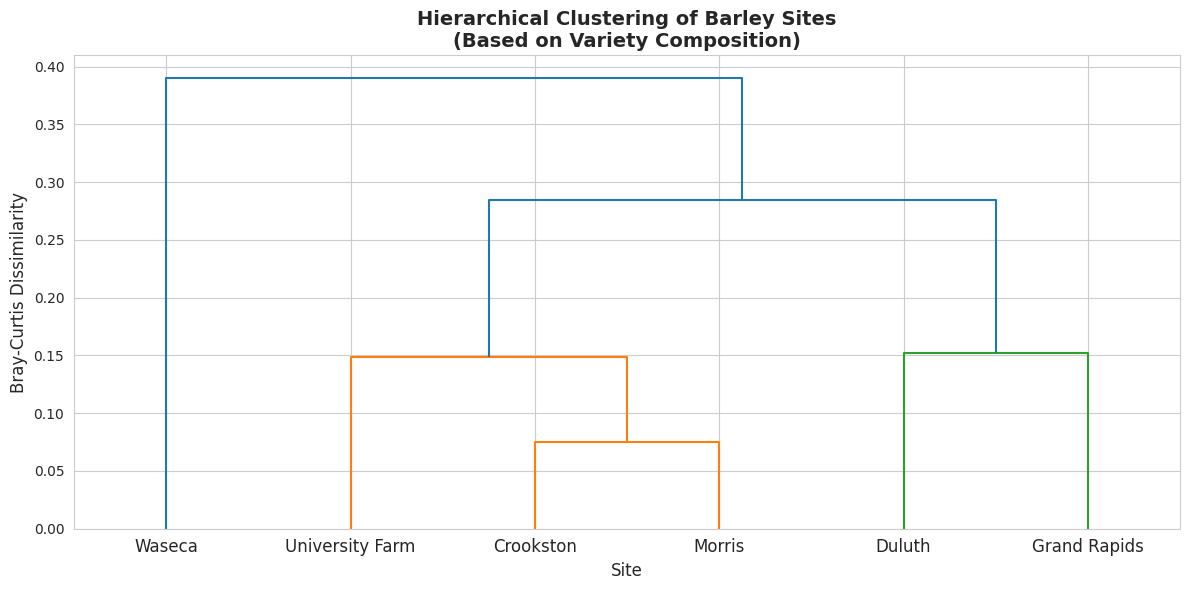

In [11]:
# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
linkage_matrix = linkage(dist_matrix, method='average')

# Plot dendrogram
fig, ax = plt.subplots(figsize=(12, 6))
dendrogram(linkage_matrix, labels=community_matrix.index, ax=ax,
           leaf_font_size=12, color_threshold=0.7*max(linkage_matrix[:, 2]))

ax.set_title('Hierarchical Clustering of Barley Sites\n(Based on Variety Composition)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Site', fontsize=12)
ax.set_ylabel('Bray-Curtis Dissimilarity', fontsize=12)

plt.tight_layout()
plt.show()

## Species Composition Heatmap

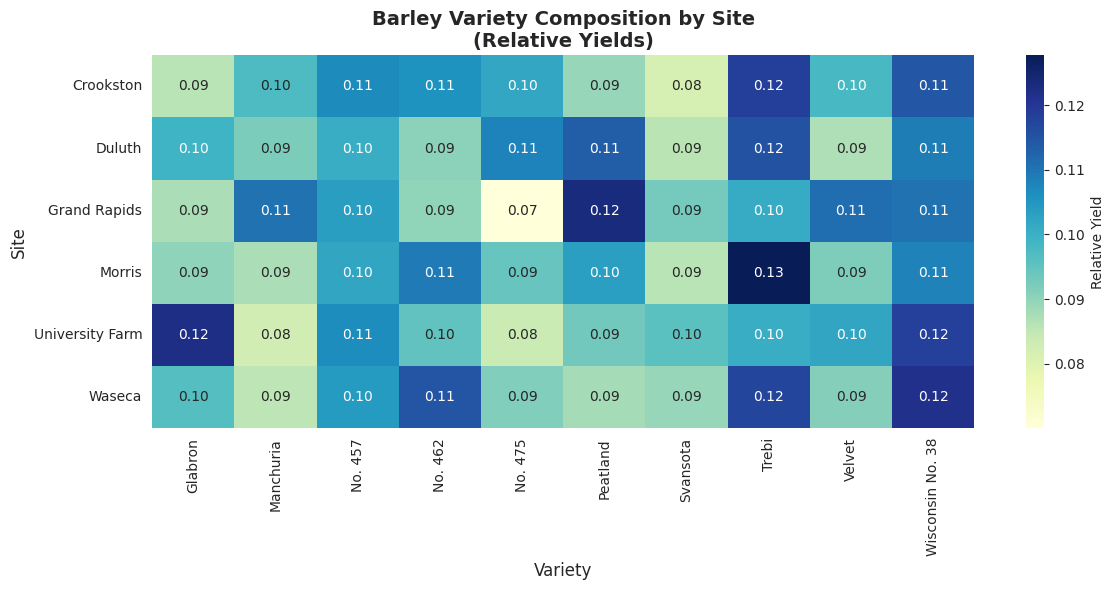

In [12]:
# Create heatmap of variety composition
fig, ax = plt.subplots(figsize=(12, 6))

# Normalize by row (site) to show relative composition
community_normalized = community_matrix.div(community_matrix.sum(axis=1), axis=0)

sns.heatmap(community_normalized, annot=True, fmt='.2f', cmap='YlGnBu', 
            cbar_kws={'label': 'Relative Yield'}, ax=ax)

ax.set_title('Barley Variety Composition by Site\n(Relative Yields)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Variety', fontsize=12)
ax.set_ylabel('Site', fontsize=12)

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:
1. Reshaping data into a community matrix format
2. Calculating multiple diversity indices
3. Performing NMDS and PCA ordination
4. Analyzing dissimilarity patterns
5. Hierarchical clustering of sites
6. Visualizing species composition

The analysis reveals patterns in barley variety performance across different sites, showing which sites have similar variety compositions and yields.